# Задача 5. Обучение без учителя

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

# Данные

Для решения данной задачи будет использован [датасет](https://www.kaggle.com/datasets/zalando-research/fashionmnist?select=fashion-mnist_train.csv)

Fashion-MNIST состоит из 60 тысяч черно-белых изображений одежды 28 на 28 пикселей, относящимся к одной из десяти категорий. Целевой признак - категория одежды.

Категории одежды:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

Датасет хранит данные в первом столбце label, в остальных значение каждого пикселя.

Импорты

In [1]:
import itertools
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Модели
from sklearn.base import BaseEstimator, ClusterMixin, clone
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.cluster import KMeans, DBSCAN,  AffinityPropagation


In [2]:
df = pd.read_csv("fashion-mnist_train.csv")

# EDA

In [3]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df["label"].value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [5]:
x = df.drop('label', axis=1)
y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

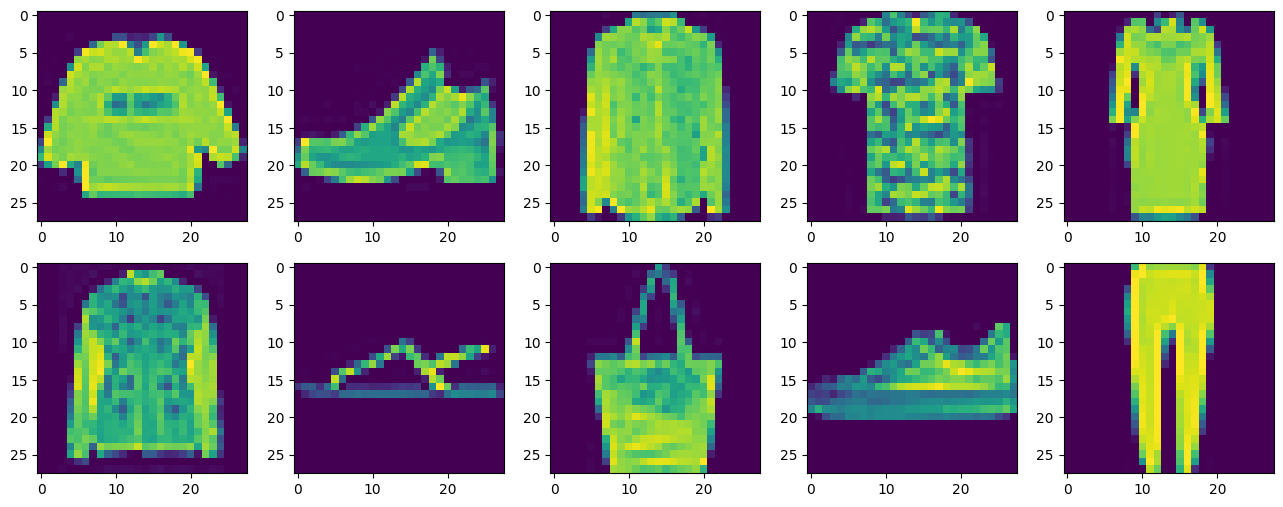

In [6]:
plt.figure(figsize=(16, 6))

x_demo = df.drop_duplicates('label').drop("label", axis=1)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_demo.to_numpy()[i, :].reshape([28, 28]));


# Визуализация данных со снижением размерности
## Использование PCA

CPU times: total: 5.92 s
Wall time: 1.89 s


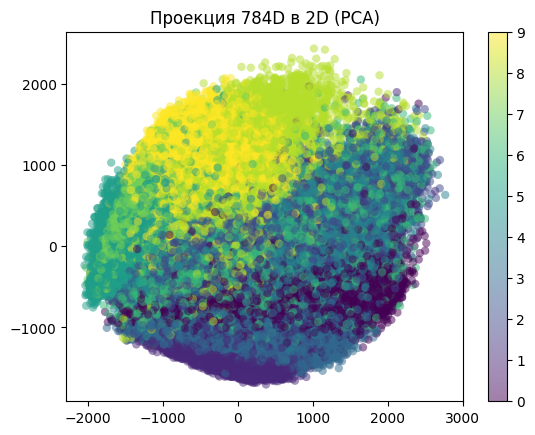

In [7]:
%%time

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train, y_train)

plt.title('Проекция %dD в 2D (PCA)' % x_train.shape[1]);
plt.scatter(
    x_pca[:, 0], 
    x_pca[:, 1], 
    c=y_train,
    edgecolor='none', alpha=0.5
)
plt.colorbar();


## Использование TSNE

CPU times: total: 36min 7s
Wall time: 9min 49s


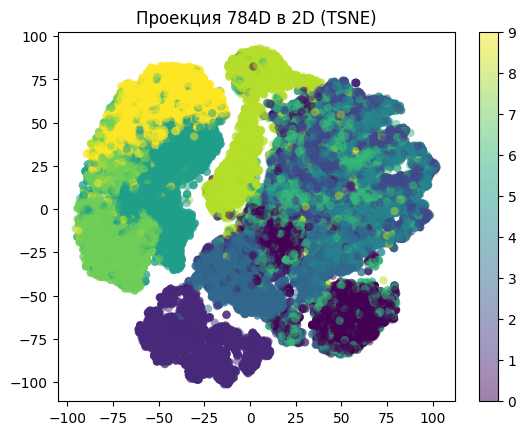

In [8]:
%%time

tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_train, y_train)


plt.title('Проекция %dD в 2D (TSNE)' % x_train.shape[1]);
plt.scatter(
    x_tsne[:, 0], 
    x_tsne[:, 1],
    c=y_train,
    edgecolor='none', 
    alpha=0.5,
)
plt.colorbar();

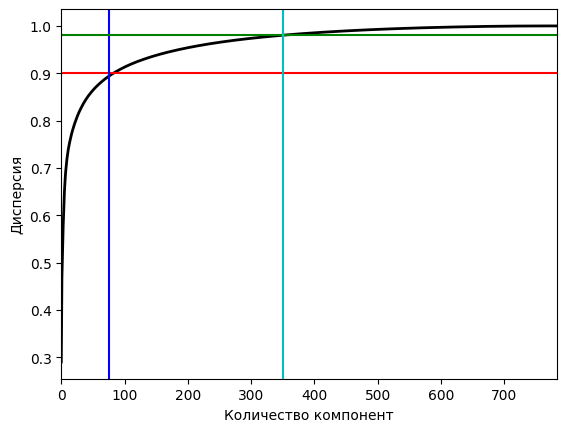

In [9]:
pca = PCA().fit(x_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Количество компонент')
plt.ylabel('Дисперсия')
plt.xlim(0, 784)
plt.axhline(0.9, c='r')
plt.axvline(75, c='b')

plt.axhline(0.98, c='g')
plt.axvline(350, c='c')
plt.show();

65 пикселей описывают 90% дисперсии, а 350 пикселей 98%.

# Собственная реализация K-Means

In [10]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, tol=0.001, random_state=None, max_iter=1000):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state
        self.max_iter = max_iter

    def predict(self, x):
        check_is_fitted(self)
        x = check_array(x)
        result = self._get_labels(x)
        return result

    def fit(self, x, y=None):
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)
        self.n_features_in_ = x.shape[1]
        i = self.random_state_.choice(len(x), size=self.n_clusters, replace=False)
        self.cluster_centers_ = x[i, :]
        max_center_shift = np.inf
        self.n_iter_ = 1

        while max_center_shift > self.tol and self.n_iter_ < self.max_iter:
            self.labels_ = self._get_labels(x)
            new_centres = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new_centres[i] = np.mean(x[self.labels_ == i], axis=0)
            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centres, axis=1))
            self.cluster_centers_ = new_centres
            self.n_iter_ += 1

        return self
    
    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


# Обучение и тестирование

In [11]:
xs = [x_train, *(PCA(n_components=n_components).fit_transform(x_train) for n_components in [30, 65, 350])]

results = []

def train_and_validate(estimator, parameters):
    paired_parameters = [[(name, v) for v in vs] for (name, vs) in parameters.items()]
    parameter_combination = list(itertools.product(*paired_parameters))
    parameter_combination = list(map(dict, parameter_combination))

    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for parameters in parameter_combination:
            estimator = clone(estimator).set_params(**parameters)
            start_t = time.perf_counter()
            pred = estimator.fit_predict(x)
            fit_predict_time = (time.perf_counter() - start_t)
            
            ari = adjusted_rand_score(y_train, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time, parameters

            ami = adjusted_mutual_info_score(y_train, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time, parameters

            fmi = fowlkes_mallows_score(y_train, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time, parameters
        
        mean_time = np.mean([best_ari[1], best_ami[1], best_fmi[1]])

        entry = {
            "Кластеризатор": estimator.__class__.__name__,
            "Размерность": x.shape[1],
            "Время обучения, секунды": mean_time,
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0],
        }

        print(f"Результаты для {entry['Кластеризатор']}:")
        print(f"  Лучшие параметры (ARI): {best_ari[2]}")
        print(f"  Лучшие параметры (AMI): {best_ami[2]}")
        print(f"  Лучшие параметры (FMI): {best_fmi[2]}")

        results.append(entry)

In [12]:
%%time

train_and_validate(MyKMeans(), {})

Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
CPU times: total: 8min 14s
Wall time: 8min 31s


In [13]:
%%time

train_and_validate(
    KMeans(n_clusters=10, n_init='auto', random_state=42),
    {"algorithm": ["lloyd", "elkan"]}
)

Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
CPU times: total: 53.1 s
Wall time: 15.2 s


In [15]:
%%time

train_and_validate(
    DBSCAN(n_jobs=4),
    { "eps": [0.5, 1, 2, 4, 8, 16],
      "min_samples": [4, 16, 64, 256]}
)

KeyboardInterrupt: 

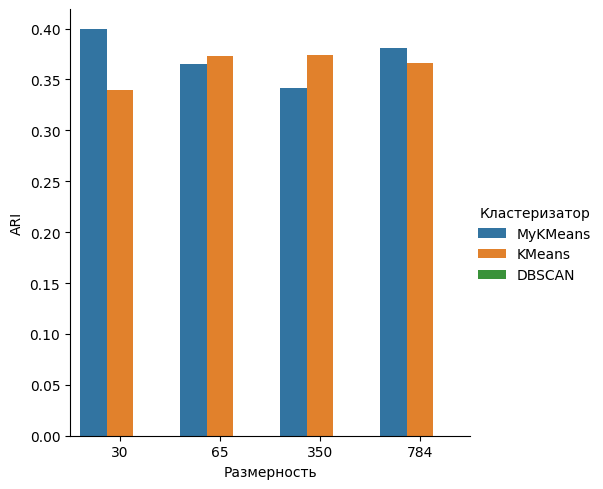

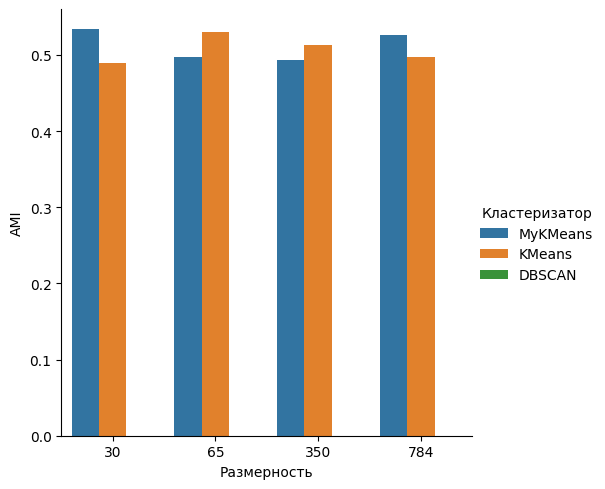

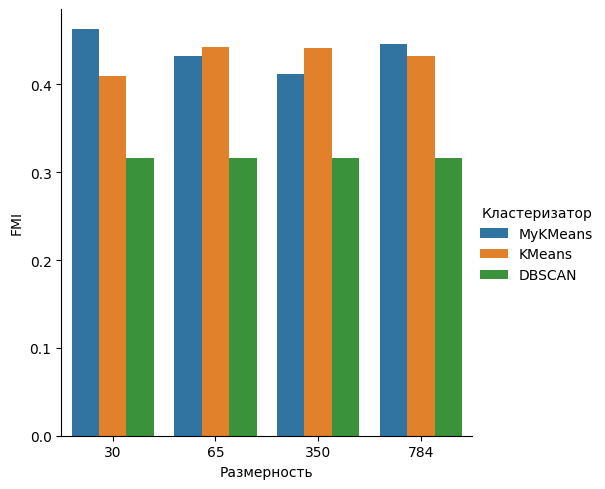

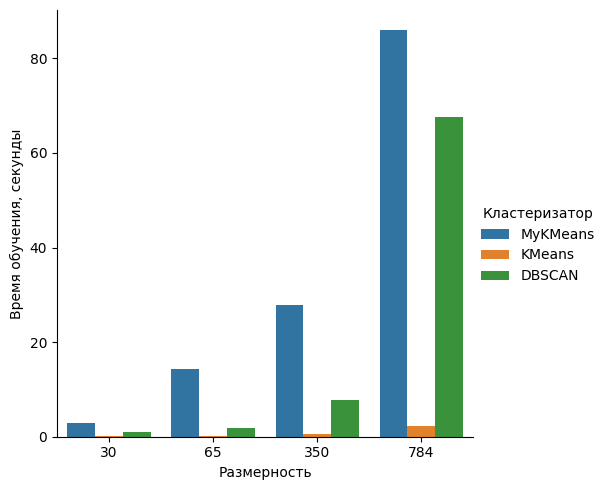

In [37]:
translated = pd.DataFrame(results)
criteria = ["ARI", "AMI", "FMI", "Время обучения, секунды"]

for m_name in criteria:
    sns.catplot(kind="bar", data=translated, x="Размерность", y=m_name, hue="Кластеризатор")
    

# Оценка 2

In [14]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [ ]:
def train_and_validate(estimator, parameters, x):
    paired_parameters = [[(name, v) for v in vs] for (name, vs) in parameters.items()]
    parameter_combination = list(itertools.product(*paired_parameters))
    parameter_combination = list(map(dict, parameter_combination))

    for params in parameter_combination:
        est = clone(estimator).set_params(**params)
        start_t = time.perf_counter()
        pred = est.fit_predict(x)  
        fit_predict_time = time.perf_counter() - start_t

        # Проверяем, есть ли кластеры
        n_clusters = len(set(pred)) - (1 if -1 in pred else 0)
        if n_clusters <= 1:
            print(f"{est.__class__.__name__} дал {n_clusters} кластер(ов). Пропуск.")
            continue

        # Вычисляем метрики
        ari = adjusted_rand_score(y_train, pred)
        ami = adjusted_mutual_info_score(y_train, pred)
        fmi = fowlkes_mallows_score(y_train, pred)
        sil = silhouette_score(x, pred)
        db = davies_bouldin_score(x, pred)

        entry = {
            "Кластеризатор": est.__class__.__name__,
            "Размерность": x.shape[1],
            "Время обучения, секунды": fit_predict_time,
            "ARI": ari,
            "AMI": ami,
            "FMI": fmi,
            "Silhouette": sil,
            "Davies-Bouldin": db,
            "Число кластеров": n_clusters,
            "Параметры": params
        }

        results.append(entry)
        print(f"{est.__class__.__name__} (eps={params['eps']}): Найдено {n_clusters} кластеров!")





In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_scaled = StandardScaler().fit_transform(x_train)  # Масштабируем перед PCA
x_reduced = PCA(n_components=50).fit_transform(x_scaled)

print(f"Размерность после PCA: {x_reduced.shape}")  # Проверяем, что всё ок


Размерность после PCA: (54000, 50)


In [ ]:
train_and_validate(
    DBSCAN(),
    {"eps": [5, 10, 20, 50], "min_samples": [3, 5]},
    x_reduced
)


DBSCAN (eps=5): Найдено 531 кластеров!
DBSCAN (eps=5): Найдено 162 кластеров!
DBSCAN (eps=10): Найдено 110 кластеров!
DBSCAN (eps=10): Найдено 35 кластеров!
DBSCAN (eps=20): Найдено 7 кластеров!
DBSCAN (eps=20): Найдено 2 кластеров!


In [1]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results = df_results[df_results["Кластеризатор"] == "DBSCAN"]
display(df_results)


NameError: name 'results' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_embedded = tsne.fit_transform(x_reduced)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=pred, palette="coolwarm", alpha=0.5)
plt.title("TSNE проекция кластеров DBSCAN")
plt.show()
